In [2]:
from pathlib import Path
import pandas as pd
import torchaudio, torch, librosa
from collections import Counter
from tqdm import tqdm
import numpy as np
import shutil

# 입력 루트
ROOT = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\YEO\datasets\감정분류대화음성\감정 분류를 위한 대화 음성 데이터셋")
PARTS = ["4차", "5차", "5_2차"]

# 출력 루트
OUTPUT_DIR = Path(r"D:\ex\최종프로젝트\AI_Dev_3rd_Project\CHOI\datasets\KES_processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
label_map = {
    "Sadness": "sad", "sadness": "sad", "sad": "sad",
    "Angry": "angry", "anger": "angry", "angry": "angry",
    "Disgust": "disgust", "disgust": "disgust",
    "Fear": "fear", "fear": "fear",
    "Neutral": "neutral", "neutral": "neutral",
    "Happiness": "happiness", "happiness": "happiness",
    "Surprise": "surprise", "surprise": "surprise"
}

def load_and_clean(part_name):
    part_dir = ROOT / part_name
    csv_file = list(part_dir.glob("*.csv"))[0]
    df = pd.read_csv(csv_file, encoding="cp949")
    # 컬럼명 교정
    df = df.rename(columns={"4번감정세기": "4번 감정세기"})
    # annotator 라벨 정규화
    for i in range(1, 6):
        col = f"{i}번 감정"
        if col in df.columns:
            df[col] = df[col].map(label_map)
    df["상황"] = df["상황"].map(label_map).fillna(df["상황"])
    # wav 경로 추가
    df["wav_path"] = df["wav_id"].apply(lambda x: str(part_dir / f"{x}.wav"))
    df["dataset_part"] = part_name
    return df

dfs = [load_and_clean(p) for p in PARTS]
full_df = pd.concat(dfs, ignore_index=True)


In [6]:
def vote_with_situation(row):
    labels = [row.get(f"{i}번 감정") for i in range(1, 6) if pd.notna(row.get(f"{i}번 감정"))]
    if not labels: return None
    cnt = Counter(labels)
    top = cnt.most_common()
    max_vote = top[0][1]
    candidates = [lab for lab, n in top if n == max_vote]

    if len(candidates) == 1:
        return candidates[0]

    # tie → 상황 1표 추가
    situation = row.get("상황")
    if pd.notna(situation):
        cnt[situation] += 1
        top2 = cnt.most_common()
        max2 = top2[0][1]
        cands2 = [lab for lab, n in top2 if n == max2]
        if len(cands2) == 1:
            return cands2[0]

    return None  # 여전히 동률이면 drop

full_df["emotion"] = full_df.apply(vote_with_situation, axis=1)
clean_df = full_df.dropna(subset=["emotion"]).copy()


In [7]:
def ensure_agreement_ratio(df):
    ann_cols = [f"{i}번 감정" for i in range(1, 6)]
    def _agg(row):
        votes = [row.get(c) for c in ann_cols if pd.notna(row.get(c))]
        if not votes: return pd.Series({"agreement_ratio": 0})
        cnt = Counter(votes)
        top = cnt.most_common(1)[0][1]
        return pd.Series({"agreement_ratio": top/len(votes)})
    out = df.apply(_agg, axis=1)
    df["agreement_ratio"] = out["agreement_ratio"]
    return df

clean_df = ensure_agreement_ratio(clean_df)

# 오디오 품질 계산
def compute_quality(path, target_sr=16000):
    try:
        y, sr = torchaudio.load(path)
        if y.shape[0] > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        if sr != target_sr:
            y = torchaudio.functional.resample(y, sr, target_sr)
        y = y.squeeze().numpy()
        dur = len(y)/target_sr
        rms = np.sqrt(np.mean(y**2))+1e-8
        peak = np.max(np.abs(y))
        crest = peak/rms
        clip_ratio = np.mean(np.abs(y) >= 0.99)
        noise_floor = np.percentile(np.abs(y), 10)
        snr_proxy = 20*np.log10(rms/(noise_floor+1e-8))
        return dur, crest, clip_ratio, snr_proxy
    except:
        return None, None, None, None

q_metrics = []
for p in tqdm(clean_df["wav_path"], desc="quality"):
    d,c,cl,s = compute_quality(p)
    q_metrics.append((d,c,cl,s))
clean_df[["duration","crest","clipping_ratio","snr_proxy_db"]] = pd.DataFrame(q_metrics)

filtered_df = clean_df[
    (clean_df["agreement_ratio"]>=0.6) &
    (clean_df["duration"]>=0.2) &
    (clean_df["snr_proxy_db"]>=10) &
    (clean_df["crest"]<=30) &
    (clean_df["clipping_ratio"]<=0.01)
].copy()


quality: 100%|██████████| 42424/42424 [06:26<00:00, 109.63it/s]


데이터 크기: 35436

컬럼 목록: ['wav_id', '발화문', '상황', '1번 감정', '1번 감정세기', '2번 감정', '2번 감정세기', '3번 감정', '3번 감정세기', '4번 감정', '4번 감정세기', '5번 감정', '5번 감정세기', '나이', '성별', 'wav_path', 'dataset_part', 'emotion', 'agreement_ratio', 'duration', 'crest', 'clipping_ratio', 'snr_proxy_db']

샘플 5행:
                     wav_id                        발화문     상황    1번 감정  \
0  5e258fd1305bcf3ad153a6a4           어, 청소 니가 대신 해 줘!  angry  neutral   
1  5e258fe2305bcf3ad153a6a5         둘 다 청소 하기 싫어. 귀찮아.  angry  neutral   
2  5e258ff5305bcf3ad153a6a6             둘 다 하기 싫어서 화내.  angry    angry   
3  5e25902f305bcf3ad153a6a9                그럼 방세는 어떡해.  angry      sad   
4  5e27f90b5807b852d9e0157b  권태긴줄 알았는데 다른 사람이 생겼나보더라고.    sad      sad   

   1번 감정세기  2번 감정  2번 감정세기    3번 감정  3번 감정세기    4번 감정  ...  나이    성별  \
0        0  angry        1  neutral        0  neutral  ...  27  male   
1        0  angry        1  neutral        0  neutral  ...  27  male   
2        1  angry        1  neutral        0    angry  ...  

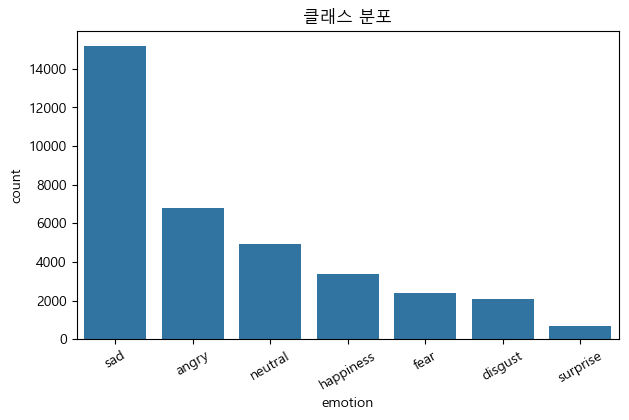


=== 감정별 평균 품질 메트릭 ===
           duration  snr_proxy_db     crest  clipping_ratio  agreement_ratio
emotion                                                                     
angry      6.235033     42.725741  8.865740    2.905307e-07         0.811024
disgust    5.911828     42.761942  8.895480    5.646240e-07         0.810480
fear       6.128945     42.456548  8.619579    2.632788e-07         0.791146
happiness  5.808141     42.917490  8.753852    4.308283e-07         0.823659
neutral    5.510167     45.592859  9.517884    1.745481e-06         0.700365
sad        6.255953     42.808786  8.735621    2.259211e-07         0.859022
surprise   5.644327     43.052443  8.758798    5.409038e-07         0.691594


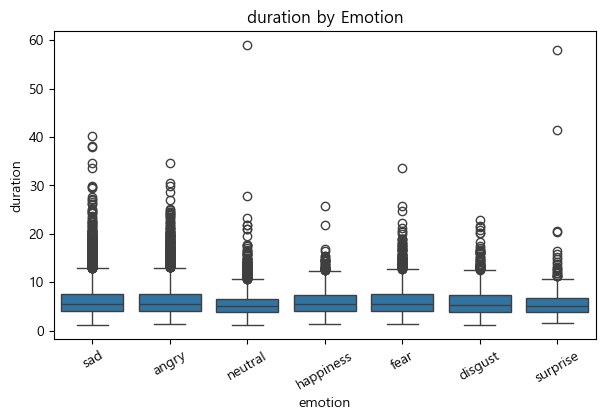

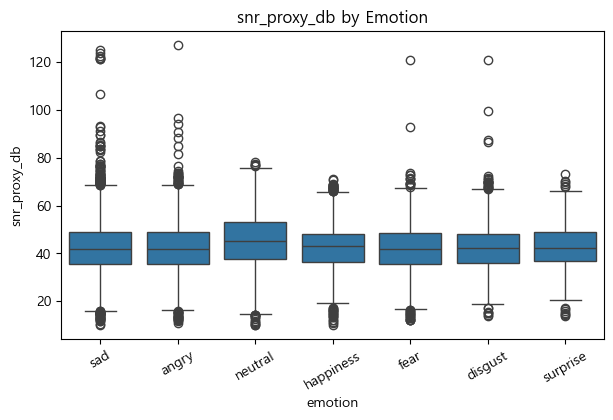

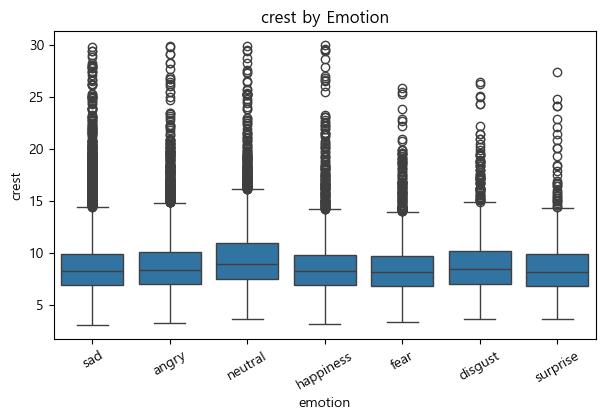

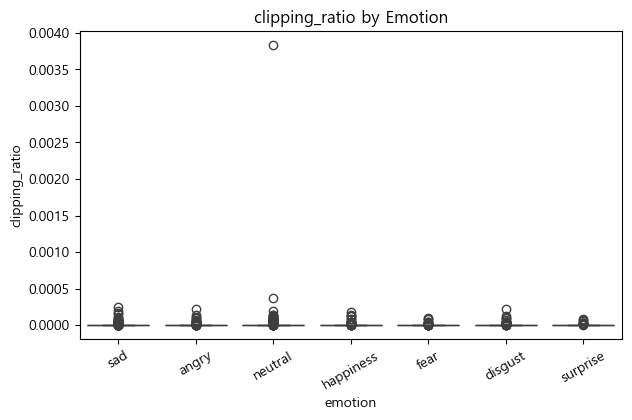

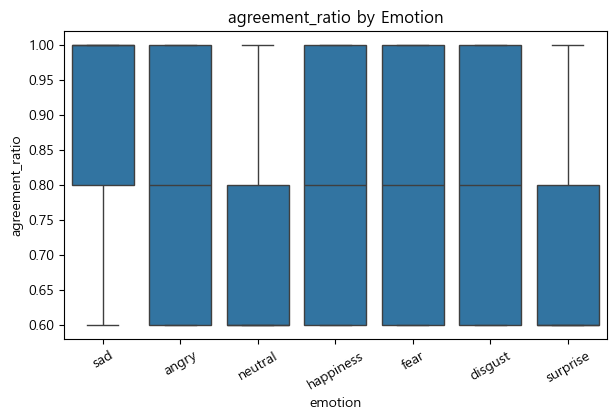

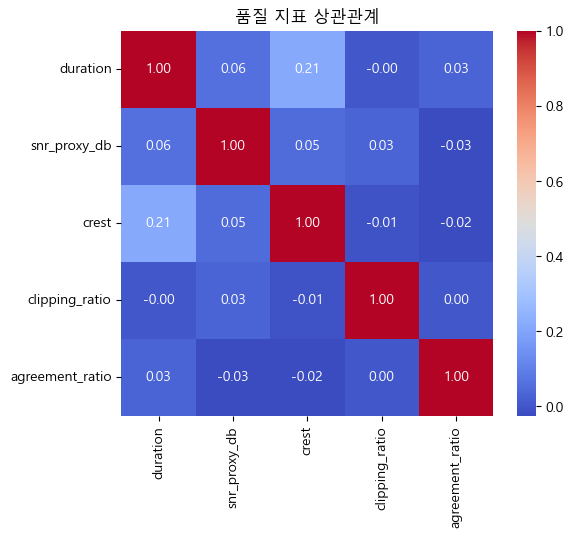

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. 기본 정보
# ------------------------------
print("데이터 크기:", len(filtered_df))
print("\n컬럼 목록:", filtered_df.columns.tolist())
print("\n샘플 5행:")
print(filtered_df.head())

# ------------------------------
# 2. 수치형 기술 통계
# ------------------------------
num_cols = ["duration", "snr_proxy_db", "crest", "clipping_ratio", "agreement_ratio"]
print("\n=== 기술 통계 요약 ===")
print(filtered_df[num_cols].describe())

# ------------------------------
# 3. 클래스 분포
# ------------------------------
print("\n=== 클래스 분포 ===")
print(filtered_df["emotion"].value_counts())

# 시각화
plt.figure(figsize=(7,4))
sns.countplot(x="emotion", data=filtered_df, order=filtered_df["emotion"].value_counts().index)
plt.title("클래스 분포")
plt.xticks(rotation=30)
plt.show()

# ------------------------------
# 4. 감정별 평균 품질 메트릭
# ------------------------------
print("\n=== 감정별 평균 품질 메트릭 ===")
print(filtered_df.groupby("emotion")[num_cols].mean())

# boxplot으로 감정별 품질 분포 비교
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="emotion", y=col, data=filtered_df, order=filtered_df["emotion"].value_counts().index)
    plt.title(f"{col} by Emotion")
    plt.xticks(rotation=30)
    plt.show()

# ------------------------------
# 5. 상관관계 매트릭스
# ------------------------------
corr = filtered_df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("품질 지표 상관관계")
plt.show()


In [18]:
target_sr = 16000

def process_and_save(row, out_dir=OUTPUT_DIR):
    src = Path(row["wav_path"])
    if not src.exists(): return None
    wav_id = row["wav_id"]

    y, sr = torchaudio.load(src)
    if y.shape[0] > 1:
        y = torch.mean(y, dim=0, keepdim=True)
    if sr != target_sr:
        y = torchaudio.functional.resample(y, sr, target_sr)
    y = y.squeeze().numpy()
    y = y/np.max(np.abs(y)+1e-8)

    L = len(y)/target_sr
    nseg = int(L//8)
    segments = []
    # 정수 세그먼트
    for i in range(nseg):
        seg = y[i*8*target_sr:(i+1)*8*target_sr]
        dest = out_dir / f"{wav_id}__seg_{i:03d}.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    # 잔여 처리
    r = L % 8
    remainder = y[nseg*8*target_sr:]

    if L < 8:
        # 🔥 8초 미만 발화도 무조건 pad해서 1개 세그먼트 생성
        seg = np.pad(y, (0, int(8*target_sr - len(y))))
        dest = out_dir / f"{wav_id}__seg_000.wav"
        torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
        segments.append(dest.name)

    elif r > 0:
        if r >= 4:
            seg = np.pad(remainder, (0, int(8*target_sr - len(remainder))))
            dest = out_dir / f"{wav_id}__seg_{nseg:03d}.wav"
            torchaudio.save(str(dest), torch.tensor(seg).unsqueeze(0), target_sr)
            segments.append(dest.name)
        # r < 4는 버림 (긴 발화 잔여)
    return segments

records = []
for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
    segs = process_and_save(row)
    if segs:
        for s in segs:
            records.append({"path": s, "emotion": row["emotion"]})

meta_df = pd.DataFrame(records)
meta_df.to_csv(OUTPUT_DIR/"metadata.csv", index=False, encoding="utf-8-sig")


segmenting: 100%|██████████| 35436/35436 [09:19<00:00, 63.34it/s] 


In [19]:
meta_df.shape

(37009, 2)

In [20]:
fail_count = 0
records = []
for idx, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="segmenting"):
    segs = process_and_save(row)
    if segs is None:
        fail_count += 1
    else:
        for s in segs:
            records.append({"path": s, "emotion": row["emotion"]})

print("실패한 파일 수:", fail_count)
print("세그먼트 총 개수:", len(records))


segmenting:  14%|█▍        | 4996/35436 [00:57<05:48, 87.39it/s] 


KeyboardInterrupt: 